In [ ]:
pip install fbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.9/385.2 MB 27.4 MB/s eta 0:00:15
   ---------------------------------------- 1.5/385.2 MB 19.3 MB/s eta 0:00:20
   ---------------------------------------- 2.4/385.2 MB 19.5 MB/s eta 0:00:20
   ---------------------------------------- 3.4/385.2 MB 19.9 MB/s eta 0:00:20
   ---------------------------------------- 4.1/385.2 MB 18.7 MB/s eta 0:00:21
    --------------------------------------- 5.0/385.2 MB 18.9 MB/s eta 0:00:21
    --------------------------------------- 5.7/385.2 MB 19.2 MB/s eta 0:00:20
    --------------------------------------- 6.7/385.2 MB 19.4 MB/s eta 0:00:20
    --------------------------------------- 7.6/385.2 MB 19.4 MB/s eta 0:00:20
    --------------------------------------- 8.6/385.2 MB 18.9 MB/s eta 0:

In [2]:
import numpy as np
from scipy.stats import zscore
import tensorflow as tf
from fbm import FBM
import pandas as pd
from matplotlib.ticker import FormatStrFormatter,MaxNLocator
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Experimental Data

In [ ]:
# Read data
data = pd.read_csv('Datasets/Experimental Data/traj_rab5.csv')

In [ ]:
data

,x,y,t,pid
0,0.696147,3.256893,0.000,0
1,0.707357,3.285189,0.020,0
2,0.752658,3.299609,0.040,0
3,0.746460,3.323723,0.060,0
4,0.778112,3.329980,0.080,0
...,...,...,...,...
5004645,15.086407,20.107943,11.964,103360
5004646,15.091018,20.151434,11.976,103360
5004647,5.173955,22.217332,11.952,103361
5004648,5.030339,22.217332,11.964,103361


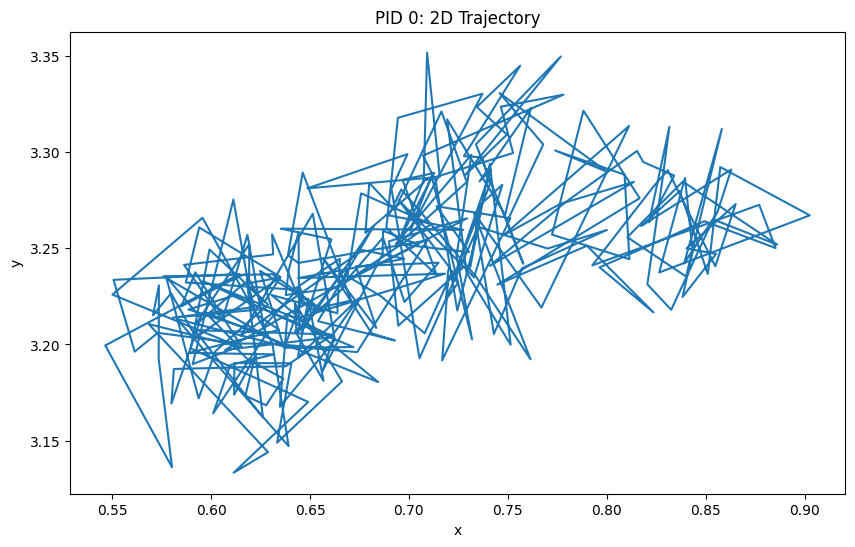

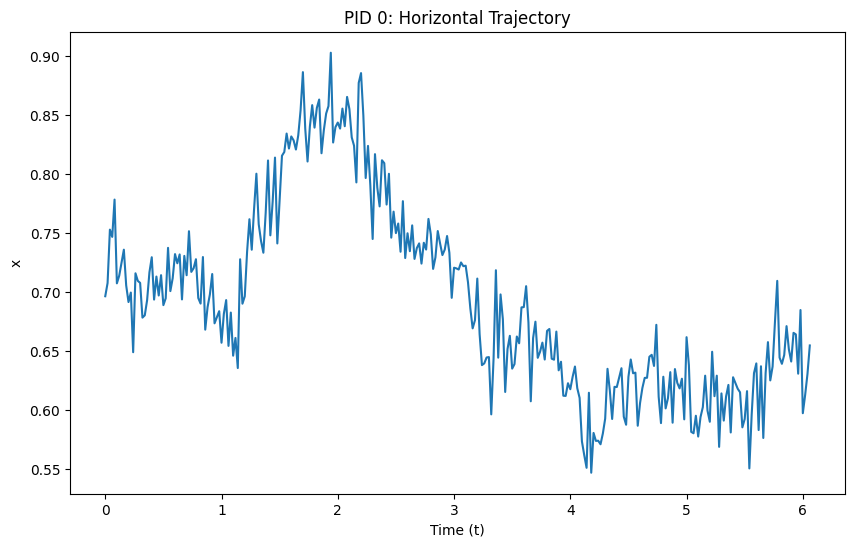

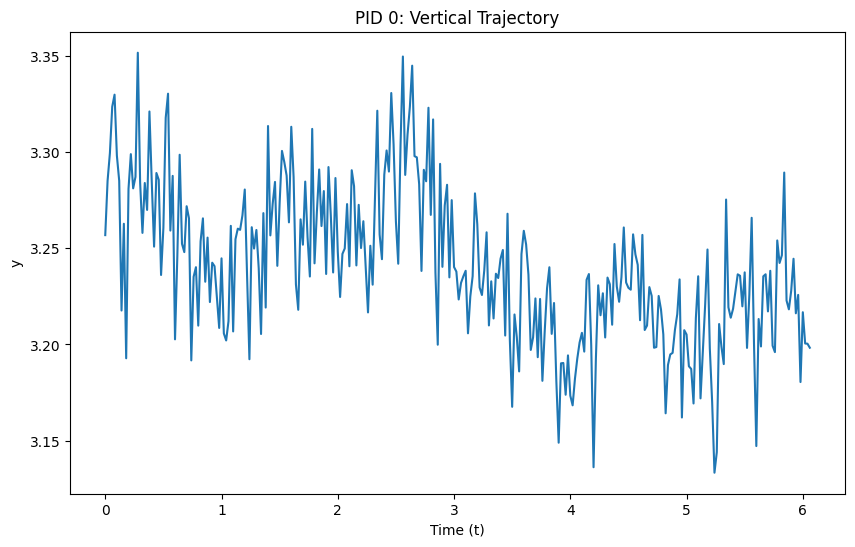

In [ ]:
# Filter data for pid = 0
data_pid0 = data[data['pid'] == 0]

# Plotting the 2D trajectory for pid = 0
plt.figure(figsize=(10, 6))
plt.plot(data_pid0['x'], data_pid0['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('PID 0: 2D Trajectory')
plt.savefig('xy.svg', format='svg')
plt.show()

# Plotting the horizontal trajectory (x over time) for pid = 0
plt.figure(figsize=(10, 6))
plt.plot(data_pid0['t'], data_pid0['x'])
plt.xlabel('Time (t)')
plt.ylabel('x')
plt.title('PID 0: Horizontal Trajectory')
plt.savefig('x.svg', format='svg')
plt.show()

# Plotting the vertical trajectory (y over time) for pid = 0
plt.figure(figsize=(10, 6))
plt.plot(data_pid0['t'], data_pid0['y'])
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('PID 0: Vertical Trajectory')
plt.savefig('y.svg', format='svg')
plt.show()

In [ ]:
data.describe()

,x,y,t,pid
count,5.004650e+06,5.004650e+06,5.004650e+06,5.004650e+06
mean,3.059922e+01,3.107081e+01,1.037709e+01,5.380196e+04
std,1.405496e+01,1.382032e+01,7.691156e+00,3.208999e+04
min,2.233785e-05,2.703566e-05,0.000000e+00,0.000000e+00
25%,1.980224e+01,2.095262e+01,4.356000e+00,2.207100e+04
50%,3.053458e+01,3.057157e+01,8.740000e+00,5.785300e+04
75%,4.122856e+01,4.127687e+01,1.450000e+01,8.228400e+04
max,6.277444e+01,6.277444e+01,2.999000e+01,1.033610e+05


In [ ]:
# Calculate the row counts for each pid
pid_counts = data['pid'].value_counts()

# Calculate the frequency of each trajectory length
trajectory_length = pid_counts.value_counts()

# Create a DataFrame with the results
trajectory_length_df = pd.DataFrame({'trajectory length': trajectory_length.index,
                                     'frequency': trajectory_length.values,
                                     'trajectory proportion (%)': trajectory_length.values * 100/ len(data['pid'].unique()),
                                     'data proportion (%)':trajectory_length.values*trajectory_length.index * 100/len(data)})

# Calculate cumulative proportions
trajectory_length_df['cumulative trajectory proportion (%)'] = trajectory_length_df['trajectory proportion (%)'].cumsum()
trajectory_length_df['cumulative data proportion (%)'] = trajectory_length_df['data proportion (%)'].cumsum()

# Sort the DataFrame by row_count in ascending order
trajectory_length_df_sorted = trajectory_length_df.sort_values(by='trajectory length', ascending=True)

# Display the table
display(trajectory_length_df_sorted[:25])

,trajectory length,frequency,trajectory proportion (%),data proportion (%),cumulative trajectory proportion (%),cumulative data proportion (%)
0,3,23620,22.851725,1.415883,22.851725,1.415883
1,4,14589,14.114471,1.166036,36.966196,2.581919
2,5,9929,9.606045,0.991977,46.572241,3.573896
3,6,7077,6.846810,0.848451,53.419051,4.422347
4,7,5419,5.242739,0.757955,58.661791,5.180302
5,8,4236,4.098218,0.677130,62.760009,5.857433
6,9,3442,3.330044,0.618984,66.090052,6.476417
7,10,2705,2.617016,0.540497,68.707068,7.016914
8,11,2364,2.287107,0.519597,70.994176,7.536511
9,12,2030,1.963971,0.486747,72.958147,8.023258


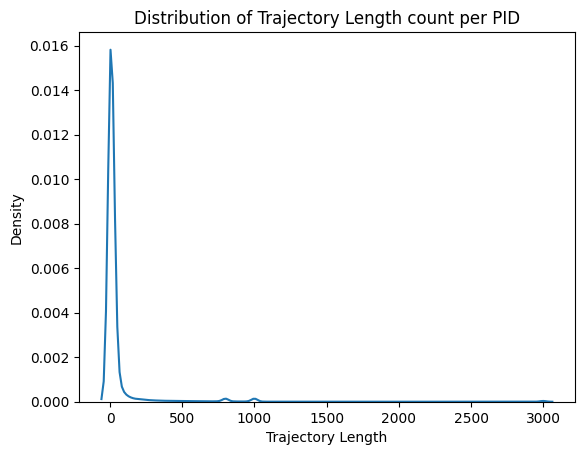

In [ ]:
# Plot the KDE of trajectory lengths
sns.kdeplot(pid_counts)
plt.xlabel('Trajectory Length')
plt.ylabel('Density')
plt.title('Distribution of Trajectory Length count per PID')
plt.savefig("KDE.svg", format='svg')
plt.show()

    time_increment   count
0            0.010  923234
1            0.010  620338
2            0.012  592266
3            0.020  574406
4            0.012  434935
5            0.010  429119
6            0.012  256373
7            0.020  217899
8            0.010  163026
9            0.020  129901
10           0.020  125609
11           0.012  122121
12           0.010   88812
13           0.010   87388
14           0.024   15321
15           0.012    8772
16           0.040    8281
17           0.020    6329
18           0.012    5867
19           0.012    5858
20           0.012    5840
21           0.012    5821
22           0.040    5370
23           0.020    5188
24           0.020    5160
25           0.020    5143
26           0.024    5120
27           0.040    4832
28           0.024    4779
29           0.010    4664
30           0.020    4238
31           0.010    3763
32           0.010    3750
33           0.010    3726
34           0.012    2922
35           0.020    2567
3

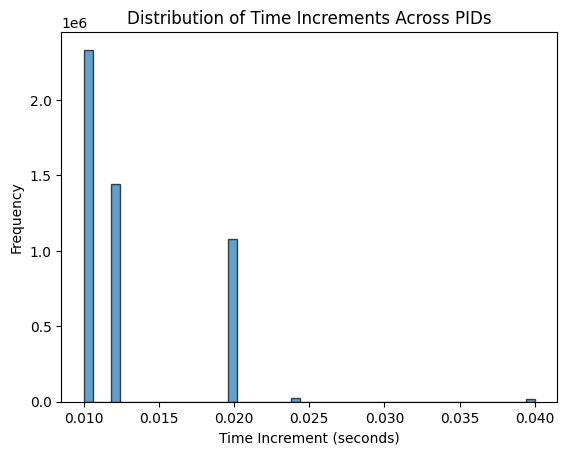

count    4.901288e+06
mean     1.298928e-02
std      4.354943e-03
min      1.000000e-02
25%      1.000000e-02
50%      1.200000e-02
75%      1.200000e-02
max      4.000000e-02
Name: t, dtype: float64


In [ ]:
# Calculate time increments for each PID
time_increments = data.groupby('pid')['t'].diff().dropna()

# Calculate the counts of each unique time increment
time_increment_counts = time_increments.value_counts().reset_index()
time_increment_counts.columns = ['time_increment', 'count']

print(time_increment_counts)

# Plot the distribution of time increments
plt.hist(time_increments, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Time Increment (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Increments Across PIDs')
plt.savefig("Time.svg", format='svg')
plt.show()

# Summary statistics
summary_stats = time_increments.describe()
print(summary_stats)

In [ ]:
# Check for inconsistent dt values per trajectory
inconsistent_pids = data.groupby('pid').apply(lambda group: group['t'].diff().dropna().nunique() > 1)

# Convert to list
inconsistent_pids = inconsistent_pids[inconsistent_pids].index.tolist()

# Print the number of pids with inconsistent time increments
print(len(inconsistent_pids))

91343


In [ ]:
# Search for mising values
print(data.isna().sum())

# Search for duplicate rows
print(data.duplicated().sum())

x      0
y      0
t      0
pid    0
dtype: int64
0


# Generate Synthetic Dataset

In [ ]:
N = 500  # Trajectory Sample Count
M = 300   # Number of time steps
dt = 0.01  # time increment
R = np.zeros(M+1)  # distances for ensemble MSD
Tmax = dt*(M+1)


trajectories = [] # Trajectories with varied generalised diffusion coefficients

original_trajectories = [] # Trajectories with fixed diffusion coefficient

for trajectory in range(N):
    H = np.random.uniform(0.01, 0.99)  # Generate a random Hurst exponent between 0.01 and 0.99
    D = np.random.uniform(0.01, 0.150)  # Generate a random diffusion coefficient between 0.01 and 0.150

    C = np.sqrt(2*D)  # Diffusion Scaler

    # generate FBM paths with D=1/2
    Wx = FBM(n=M+1, hurst=H, length=Tmax, method='cholesky').fbm()
    Wy = FBM(n=M+1, hurst=H, length=Tmax, method='cholesky').fbm()

    XT = np.zeros(M+1)  # Horizontal Trajectory
    YT = np.zeros(M+1)  # Vertical Trajectory
    t = np.zeros(M+1)  # Time array

    XT[0] = XT[0] + np.random.normal(0, 0.01)
    YT[0] = YT[0] + np.random.normal(0, 0.01)


    # Initial values at t=0
    trajectories.append({'x': XT[0], 'y': YT[0], 't': t[0], 'pid': trajectory, 'H': H, 'Diffusion': D})
    original_trajectories.append({'x': Wx[0], 'y': Wy[0], 't': t[0], 'pid': trajectory, 'H': H})

    # Constructing Synthetic Dataset
    for i in range(1, M+1):

       # Generating fBm trajectories with modified diffusion
        GX = C * (Wx[i] - Wx[i-1])
        Gy = C * (Wy[i] - Wy[i-1])

        # Transform fGn back to fBm
        XT[i] = XT[i-1] + GX + np.random.normal(0, 0.01)
        YT[i] = YT[i-1] + Gy + np.random.normal(0, 0.01)
        t[i] = i * dt

        # Append to synthetic dataframe
        trajectories.append({'x': XT[i], 'y': YT[i], 't': t[i], 'pid': trajectory, 'H': H, 'Diffusion': D})
        original_trajectories.append({'x': Wx[i], 'y': Wy[i], 't': t[i], 'pid': trajectory, 'H': H})

        # construct ensemble MSD for FBM with new Diffusion Coefficient
        R[i] = R[i] + (XT[i] - XT[0])**2 + (YT[i] - YT[0])**2

# Convert data list to DataFrame and export it
trajectories = pd.DataFrame(synthetic_dataset)
trajectories.to_csv('synthetic_dataset.csv', index=False)

original_trajectories = pd.DataFrame(original_trajectories)
original_trajectories.to_csv('original_trajectories.csv', index=False)

# Ensemble MSD of trajectories list (varied diffusion data)
EMSD = R / N
EMSD_data = pd.DataFrame({'Time': np.arange(M+1)*dt ,'EMSD': EMSD})
EMSD_data.to_csv('EMSD_data.csv', index=False)

In [ ]:
trajectories = pd.read_csv('Datasets/Train-Test Datasets/trajectories.csv')
original_trajectories = pd.read_csv('Datasets/Train-Test Datasets/original_trajectories.csv')

In [ ]:
EMSD_data

,Time,EMSD
0,0.00,0.000000
1,0.01,0.034874
2,0.02,0.042168
3,0.03,0.051365
4,0.04,0.047859
...,...,...
296,2.96,1.214673
297,2.97,1.228929
298,2.98,1.215214
299,2.99,1.231515


In [ ]:
trajectories

,x,y,t,pid,H,Diffusion
0,-0.002177,0.016407,0.00,0,0.123366,0.105387
1,-0.276301,0.108027,0.01,0,0.123366,0.105387
2,-0.306908,0.328290,0.02,0,0.123366,0.105387
3,-0.256130,0.395778,0.03,0,0.123366,0.105387
4,-0.268786,0.240710,0.04,0,0.123366,0.105387
...,...,...,...,...,...,...
150495,-0.384673,-0.665036,2.96,499,0.089344,0.077477
150496,-0.658285,-0.798245,2.97,499,0.089344,0.077477
150497,-0.186344,-0.451094,2.98,499,0.089344,0.077477
150498,-0.818116,-0.791757,2.99,499,0.089344,0.077477


In [ ]:
original_trajectories

,x,y,t,pid,H
0,0.000000,0.000000,0.00,0,0.123366
1,-0.625854,0.173138,0.01,0,0.123366
2,-0.690506,0.652103,0.02,0,0.123366
3,-0.599802,0.798369,0.03,0,0.123366
4,-0.620754,0.463284,0.04,0,0.123366
...,...,...,...,...,...
150495,-0.375482,-1.564590,2.96,499,0.089344
150496,-1.062751,-1.929627,2.97,499,0.089344
150497,0.071882,-1.105996,2.98,499,0.089344
150498,-1.488645,-1.951084,2.99,499,0.089344


In [ ]:
# Function that takes trajectory data and computes EMSD = 4*Diffusion*t^2H
def theoretical_emsd(data):
    # Ensure 't' is treated as numeric
    data['t'] = pd.to_numeric(data['t'], errors='coerce')

    # Group data by 'pid'
    grouped = data.groupby('pid')

    # Create a DataFrame to store MSD values for each time point
    time_points = sorted(data['t'].unique())
    msd_values = {t: [] for t in time_points}

    for pid, group in grouped:
        # Extract D and H for the current pid
        D = group['Diffusion'].iloc[0]
        H = group['H'].iloc[0]

        # Calculate MSD for this trajectory at each time point
        for t in time_points:
            # Theoretical MSD for this time point
            msd = 4 * D * t**(2 * H)
            msd_values[t].append(msd)

    # Calculate the ensemble average MSD at each time point
    emsd = np.array([np.mean(msd_values[t]) for t in time_points])

    return emsd

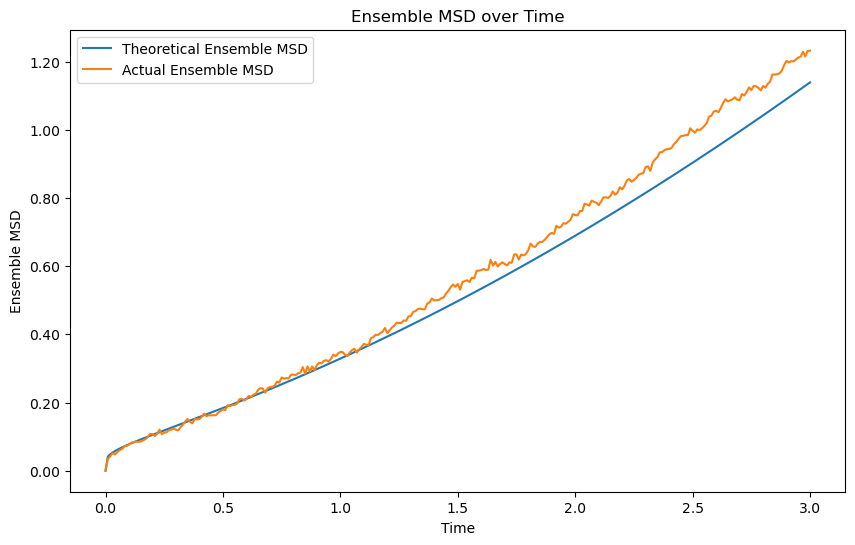

In [ ]:
# Plotting Theoretical and Actual Ensemble MSD of trajectories list

EMSD_power_law = theoretical_emsd(synthetic_dataset)
time_vals =  synthetic_dataset['t'].unique()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_vals, EMSD_power_law, label='Theoretical Ensemble MSD')
plt.plot(EMSD_data['Time'], EMSD_data['EMSD'], label='Actual Ensemble MSD')
plt.xlabel('Time')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('Ensemble MSD')
plt.title('Ensemble MSD over Time')
plt.legend()
plt.savefig("EMSD_comparison.svg", format='svg')
plt.show()

# Deep Learning Model

# Transform Synthetic Dataset

In [7]:
# Function to apply differencing within each pid and update original columns
def differencing(group):

    # Compute the differenced values
    group['x'] = group['x'].diff()
    group['y'] = group['y'].diff()

    # Drop the first row with NaN due to differencing
    group = group.dropna()


    return group

In [8]:
# Apply differencing to trajectories dataframe
differenced_trajectories = trajectories.groupby('pid').apply(differencing).reset_index(drop=True)

# Normalising x,y to interval [-1,1]
scaled_trajectories = differenced_trajectories.copy()

xMin, xMax = differenced_trajectories['x'].min(), differenced_trajectories['x'].max()

yMin, yMax = differenced_trajectories['y'].min(), differenced_trajectories['y'].max()

scaled_trajectories['x'] = 2*(differenced_trajectories['x'] - xMin)/(xMax- xMin) - 1

scaled_trajectories['y'] = 2*(differenced_trajectories['y'] - yMin)/(yMax- yMin) - 1

In [9]:
differenced_trajectories.describe()

,x,y,t,pid,H,Diffusion
count,150000.000000,150000.000000,150000.000000,150000.00000,150000.000000,150000.000000
mean,-0.000062,0.000014,1.505000,249.50000,0.470117,0.082221
std,0.144084,0.144906,0.866023,144.33776,0.285227,0.040130
min,-1.415612,-1.618640,0.010000,0.00000,0.014306,0.010505
25%,-0.026193,-0.026145,0.757500,124.75000,0.229940,0.047437
50%,-0.000189,-0.000032,1.505000,249.50000,0.459194,0.083491
75%,0.026017,0.026432,2.252500,374.25000,0.727734,0.116806
max,1.549935,1.764917,3.000000,499.00000,0.984866,0.149652


In [10]:
scaled_trajectories.describe()

,x,y,t,pid,H,Diffusion
count,150000.000000,150000.000000,150000.000000,150000.00000,150000.000000,150000.000000
mean,-0.045336,-0.043224,1.505000,249.50000,0.470117,0.082221
std,0.097172,0.085653,0.866023,144.33776,0.285227,0.040130
min,-1.000000,-1.000000,0.010000,0.00000,0.014306,0.010505
25%,-0.062960,-0.058686,0.757500,124.75000,0.229940,0.047437
50%,-0.045422,-0.043250,1.505000,249.50000,0.459194,0.083491
75%,-0.027749,-0.027608,2.252500,374.25000,0.727734,0.116806
max,1.000000,1.000000,3.000000,499.00000,0.984866,0.149652


In [11]:
scaled_trajectories

,x,y,t,pid,H,Diffusion
0,-0.230168,0.010925,0.01,0,0.123366,0.105387
1,-0.065936,0.086964,0.02,0,0.123366,0.105387
2,-0.011049,-0.003339,0.03,0,0.123366,0.105387
3,-0.053830,-0.134891,0.04,0,0.123366,0.105387
4,0.105962,-0.048308,0.05,0,0.123366,0.105387
...,...,...,...,...,...,...
149995,-0.020157,-0.109844,2.96,499,0.089344,0.077477
149996,-0.229822,-0.121971,2.97,499,0.089344,0.077477
149997,0.272988,0.161967,2.98,499,0.089344,0.077477
149998,-0.471369,-0.244595,2.99,499,0.089344,0.077477


In [12]:
# Function to create sliding window arrays
def create_sequences(data, sequence_length):
    X = []  # Input data
    y = []  # Target Hurst data

    # Extract X and y from the dataset
    for id_value, group in data.groupby('pid'):
        # Get the unique H value for this id
        hurst_value = group['H'].iloc[0]
        y.extend([hurst_value] * (len(group) - sequence_length))

        # Extract sequence of features
        for i in range(len(group) - sequence_length):
            sequence = group.iloc[i:i + sequence_length][['x', 'y']].values
            X.append(sequence)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
#Creating Sequences for window size 3,8,13,18,23

X_3, y_3 = create_sequences(scaled_trajectories, 3)
X_8, y_8 = create_sequences(scaled_trajectories, 8)
X_13, y_13 = create_sequences(scaled_trajectories, 13)
X_18, y_18 = create_sequences(scaled_trajectories, 18)
X_23, y_23 = create_sequences(scaled_trajectories, 23)

# Hyperparameter tuning


In [ ]:
# fBm Model Architecture Function based on 3 hidden layers
def fBm_build_architecture1(input_shape, units, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape, activation='tanh'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='relu'))  # Assuming regression problem

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model


# fBm Model Architecture Function based on 2 hidden layers
def fBm_build_architecture2(input_shape, units, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape, activation='tanh'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='relu'))  # Assuming regression problem

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate the model
def fBm_train(X_train, y_train, X_test, y_test, units, learning_rate, model_builder, epochs=15, batch_size=150):
    model = model_builder((X_train.shape[1], X_train.shape[2]), units, learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])

    loss = model.evaluate(X_test, y_test)
    return loss, model

# Hyperparamater lists
units_list = [32,64,128]
learning_rates = [0.01, 0.001, 0.0001]

# Windows
window_sizes = [3, 8, 13, 18, 23]

data_dict = {
    3: (X_3, y_3),
    8: (X_8, y_8),
    13: (X_13, y_13),
    18: (X_18, y_18),
    23: (X_23, y_23)
}



In [ ]:
#Training varied diffusion model on 3 Hidden Layers

best_hyperparameters = {}
trained_models = {}

for window_size, (X, y) in data_dict.items():
    # Split data for this window size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_loss = float('inf')
    best_params = None
    best_model = None

    for units in units_list:
        for learning_rate in learning_rates:
            print(f"Training model with window size {window_size}, units={units}, learning_rate={learning_rate}")

            loss, model = fBm_train(X_train, y_train, X_test, y_test, units, learning_rate,fBm_build_architecture1)

            if loss < best_loss:
                best_loss = loss
                best_params = {'units': units, 'learning_rate': learning_rate}
                best_model = model

    best_hyperparameters[window_size] = best_params
    trained_models[window_size] = best_model

# Print best hyperparameters for each window size
for window_size, params in best_hyperparameters.items():
    print(f"Best hyperparameters for window size {window_size}:")
    print(f"Units: {params['units']}, Learning Rate: {params['learning_rate']}")

Training model with window size 3, units=32, learning_rate=0.01
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


792/792 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1612 - val_loss: 0.0806
Epoch 2/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0812 - val_loss: 0.0831
Epoch 3/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0808 - val_loss: 0.0793
Epoch 4/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0800 - val_loss: 0.0802
Epoch 5/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0804 - val_loss: 0.0794
Epoch 6/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0799 - val_loss: 0.0810
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0789
Training model with window size 3, units=32, learning_rate=0.001
Epoch 1/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2417 - val_loss: 0.1343
Epoch 2/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1227 - val_loss: 0.1053
Epoch 3/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1042 - val_loss: 0.0961
Epoch 4/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0946 - val_loss: 0.0890
Epoch 5/15
792/792 ━━━━━━━━━━━

In [ ]:
# Export
for window_size, model in trained_models.items():
    model.save(f"3HL_model_{window_size}.keras")

In [ ]:
# Training varied diffusion model in 2 Hidden layers

best_hyperparameters_2 = {}
trained_models_2 = {}

for window_size, (X, y) in data_dict.items():
    # Split data for this window size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_loss = float('inf')
    best_params = None
    best_model = None

    for units in units_list:
        for learning_rate in learning_rates:
            print(f"Training model with window size {window_size}, units={units}, learning_rate={learning_rate}")

            loss, model = fBm_train(X_train, y_train, X_test, y_test, units, learning_rate,fBm_build_architecture2)

            if loss < best_loss:
                best_loss = loss
                best_params = {'units': units, 'learning_rate': learning_rate}
                best_model = model

    best_hyperparameters_2[window_size] = best_params
    trained_models_2[window_size] = best_model

# Print best hyperparameters for each window size
for window_size, params in best_hyperparameters_2.items():
    print(f"Best hyperparameters for window size {window_size}:")
    print(f"Units: {params['units']}, Learning Rate: {params['learning_rate']}")

Training model with window size 3, units=32, learning_rate=0.01
Epoch 1/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1648 - val_loss: 0.0819
Epoch 2/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0821 - val_loss: 0.0808
Epoch 3/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0811 - val_loss: 0.0783
Epoch 4/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0800 - val_loss: 0.0805
Epoch 5/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0804 - val_loss: 0.0790
Epoch 6/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0799 - val_loss: 0.0802
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0781
Training model with window size 3, units=32, learning_rate=0.001
Epoch 1/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2174 - val_loss: 0.1168
Epoch 2/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1132 - val_loss: 0.0994
Epoch 3/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0981 - val_loss: 0.0914
Epoch 4/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
# Export
for window_size, model in trained_models_2.items():
    model.save(f"2HL_model_{window_size}.keras")

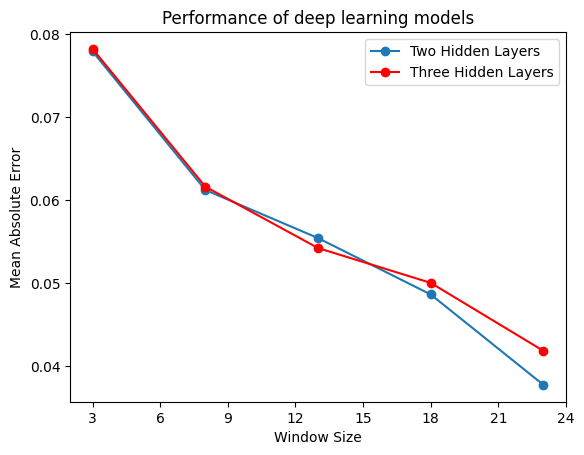

In [ ]:
# Graphing best MAE performances of the varied diffusion model

three_layer=  [0.0782, 0.0616, 0.0542, 0.0500, 0.0418]# The MAE Scores found from the three hidden layer model

two_layer= [0.0779, 0.0612, 0.0554, 0.0486, 0.0377] # The MAE Scores found from the two hidden layer model

plt.plot([3,8,13,18,23], two_layer, marker='o',label='Two Hidden Layers')
plt.plot([3,8,13,18,23], three_layer, marker='o', color ='red', label='Three Hidden Layers')
plt.xlabel('Window Size')
plt.ylabel('Mean Absolute Error')
plt.title('Performance of deep learning models')

# Setting x-axis to show only whole numbers
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.yticks([0.04, 0.05,0.06,0.07,0.08])


plt.legend()
plt.savefig("elbow.svg", format='svg')

plt.show()

In [ ]:
# Creating a baseline model using trajectory data without modified diffusion coefficients

# Preprocessing data

differenced_original_data = original_trajectories.groupby('pid').apply(differencing).reset_index(drop=True)

scaled_original_data = differenced_original_data.copy()

orig_xMin, orig_xMax = differenced_original_data['x'].min(), differenced_original_data['x'].max()

orig_yMin, orig_yMax = differenced_original_data['y'].min(), differenced_original_data['y'].max()

scaled_original_data['x'] = 2*(scaled_original_data['x'] - orig_xMin)/(orig_xMax- orig_xMin) - 1

scaled_original_data['y'] = 2*(scaled_original_data['y'] - orig_yMin)/(orig_yMax- orig_yMin) - 1

X_orig, y_orig = create_sequences(scaled_original_data, 23)

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig ,test_size=0.2)

# Training model

loss, baseline_model = fBm_train(X_train, y_train, X_test, y_test,128,0.01, fBm_build_architecture2)

baseline_model.save('baseline_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 71s 92ms/step - loss: 0.1652 - val_loss: 0.0271
Epoch 2/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 75s 83ms/step - loss: 0.0244 - val_loss: 0.0256
Epoch 3/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - loss: 0.0224 - val_loss: 0.0208
Epoch 4/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 63s 86ms/step - loss: 0.0215 - val_loss: 0.0197
Epoch 5/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 61s 83ms/step - loss: 0.0205 - val_loss: 0.0188
Epoch 6/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - loss: 0.0200 - val_loss: 0.0183
Epoch 7/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - loss: 0.0192 - val_loss: 0.0204
Epoch 8/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - loss: 0.0189 - val_loss: 0.0177
Epoch 9/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 10/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 11/15
739/739 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 12/15
739/739 ━━━━━━━━━━

# Validation Datasets (Simulated Trajectories)

In [14]:
def validation_maker(filename, N=500, M=300, dt=0.01, target_nsr=0, save=True):
    """
    Generate synthetic validation datasets using Fractional Brownian Motion (FBM) with optional Gaussian noise.

    Parameters:
    - N (int): Number of trajectories to generate. Default is 500.
    - M (int): Number of time steps for each trajectory. Default is 300.
    - dt (float): Time increment for each step. Default is 0.01.
    - target_nsr (float): Target Gaussian noise. Default is 0.
    - save (bool): Whether to save the generated dataset to a CSV file. Default is True.
    - filename (str): Name of the CSV file to save the dataset. Default is 'validation.csv'.

    Returns:
    - validation_df (pd.DataFrame): DataFrame containing the synthetic validation dataset.
    - nsr (float): The calculated noise-to-signal ratio.

    The generated dataset includes the following columns:
    - 'x': x-coordinate of the trajectory point
    - 'y': y-coordinate of the trajectory point
    - 't': Time step
    - 'pid': Trajectory ID
    - 'H': Hurst exponent used to generate the trajectory
    - 'Diffusion': Diffusion coefficient used to generate the trajectory
    """

    Tmax = dt * (M + 1)
    v = []
    trajectories_no_noise = []
    trajectories_with_noise = []

    for trajectory in range(N):
        H = np.random.uniform(0.01, 0.99)  # Generate a random Hurst exponent between 0.01 and 0.99
        D = np.random.uniform(0.01, 0.150)  # Generate a random diffusion coefficient between 0.01 and 0.150

        C = np.sqrt(2 * D)  # Diffusion Scaler

        # Generate FBM paths with D=1/2
        Wx = FBM(n=M+1, hurst=H, length=Tmax, method='cholesky').fbm()
        Wy = FBM(n=M+1, hurst=H, length=Tmax, method='cholesky').fbm()

        XT_no_noise = np.zeros(M + 1)  # Horizontal Trajectory without noise
        YT_no_noise = np.zeros(M + 1)  # Vertical Trajectory without noise
        XT_with_noise = np.zeros(M + 1)  # Horizontal Trajectory with noise
        YT_with_noise = np.zeros(M + 1)  # Vertical Trajectory with noise
        t = np.zeros(M + 1)  # Time array

        # Adding Gaussian noise if specified
        signal_x = np.var(np.concatenate(([0], np.cumsum(C*np.diff(Wx)))))
        signal_y = np.var(np.concatenate(([0], np.cumsum(C*np.diff(Wy)))))
        noise_std_x = np.sqrt(target_nsr*signal_x)
        noise_std_y = np.sqrt(target_nsr*signal_y)


        XT_with_noise[0] = XT_no_noise[0] + np.random.normal(0, noise_std_x)
        YT_with_noise[0] = YT_no_noise[0] + np.random.normal(0, noise_std_y)

        # Initial values at t=0
        v.append({'x': XT_with_noise[0], 'y': YT_with_noise[0], 't': t[0], 'pid': trajectory, 'H': H, 'Diffusion': D})

        # Constructing Synthetic Dataset
        for i in range(1, M + 1):
            # Generating fBm trajectories with modified diffusion
            GX = C * (Wx[i] - Wx[i-1])
            GY = C * (Wy[i] - Wy[i-1])

            # Transform fGn back to fBm and add noise
            XT_no_noise[i] = XT_no_noise[i-1] + GX
            YT_no_noise[i] = YT_no_noise[i-1] + GY
            XT_with_noise[i] = XT_no_noise[i] + np.random.normal(0, noise_std_x)
            YT_with_noise[i] = YT_no_noise[i] + np.random.normal(0, noise_std_y)
            t[i] = i * dt

            # Append to synthetic dataframe
            v.append({'x': XT_with_noise[i], 'y': YT_with_noise[i], 't': t[i], 'pid': trajectory, 'H': H, 'Diffusion': D})

        trajectories_no_noise.append((XT_no_noise, YT_no_noise))
        trajectories_with_noise.append((XT_with_noise, YT_with_noise))

    # Convert data list to DataFrame
    validation_df = pd.DataFrame(v)

    # Save DataFrame to CSV if specified
    if save:
        validation_df.to_csv(filename, index=False)

    # Calculate Noise-to-Signal Ratio (NSR)
    def calculate_nsr(trajectories_no_noise, trajectories_with_noise):
        noise_power = []
        signal_power = []

        for (XT_no_noise, YT_no_noise), (XT_with_noise, YT_with_noise) in zip(trajectories_no_noise, trajectories_with_noise):
            noise_x = XT_with_noise - XT_no_noise
            noise_y = YT_with_noise - YT_no_noise

            noise_power.append(np.var(noise_x) + np.var(noise_y))
            signal_power.append(np.var(XT_no_noise) + np.var(YT_no_noise))

        average_noise_power = np.mean(noise_power)
        average_signal_power = np.mean(signal_power)

        nsr = average_noise_power / average_signal_power
        return nsr

    nsr = calculate_nsr(trajectories_no_noise, trajectories_with_noise)
    return validation_df, nsr

In [15]:
# Preprocess function for validation data
def preprocess_validation(v, window_size, xMin, xMax, yMin, yMax):
    v_diff = v.groupby('pid').apply(differencing).reset_index(drop=True)


    # Normalising x,y with min max parameters
    scaled_v = v_diff.copy()

    scaled_v['x'] = 2*(v_diff['x'] - xMin)/(xMax- xMin) - 1

    scaled_v['y'] = 2*(v_diff['y'] - yMin)/(yMax- yMin) - 1

    X, y = create_sequences(scaled_v, window_size)
    return np.array(X), np.array(y)

In [ ]:
model = load_model('Models/model.keras')

baseline_model = load_model('Models/baseline_model.keras')

In [18]:
# Generate v1 with dt=0.01
v1, _ = validation_maker('v1.csv', N=100, M=300, dt=0.01, save=True)

# Preprocess validation data for v1
X_val1, y_val1 = preprocess_validation(v1, 23, xMin, xMax, yMin, yMax)
orig_X_val1, orig_y_val1 = preprocess_validation(v1, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new dt
MAE1 = model.evaluate(X_val1, y_val1, verbose=0)
print("Varied Diffusion Model MAE (dt=0.01):", MAE1)

# Evaluate the original trajectory model with the new dt
orig_MAE1 = baseline_model.evaluate(orig_X_val1, orig_y_val1, verbose=0)
print("Model without varied diffusion MAE (dt=0.01):", orig_MAE1)

Varied Diffusion Model MAE (dt=0.01): 0.05900369584560394
Model without varied diffusion MAE (dt=0.01): 0.1550540328025818


In [19]:
# Generate v2 with dt=0.012
v2, _ = validation_maker('v2.csv', N=100, M=300, dt=0.012, save=True)

# Preprocess validation data for v2
X_val2, y_val2 = preprocess_validation(v2, 23, xMin, xMax, yMin, yMax)
orig_X_val2, orig_y_val2 = preprocess_validation(v2, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new dt
MAE2 = model.evaluate(X_val2, y_val2, verbose=0)
print("Varied Diffusion Model MAE (dt=0.012):", MAE2)

# Evaluate the original trajectory model with the new dt
orig_MAE2 = baseline_model.evaluate(orig_X_val2, orig_y_val2, verbose=0)
print("Model without varied diffusion MAE (dt=0.012):", orig_MAE2)

Varied Diffusion Model MAE (dt=0.012): 0.061840321868658066
Model without varied diffusion MAE (dt=0.012): 0.15276265144348145


In [ ]:
# Generate v3 with dt=0.02
v3, _ = validation_maker('v3.csv', N=100, M=300, dt=0.02, save=True)

# Preprocess validation data for v3
X_val3, y_val3 = preprocess_validation(v3, 23, xMin, xMax, yMin, yMax)
orig_X_val3, orig_y_val3 = preprocess_validation(v3, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new dt
MAE3 = model.evaluate(X_val3, y_val3, verbose=0)
print("Varied Diffusion Model MAE (dt=0.02):", MAE3)

# Evaluate the original trajectory model with the new dt
orig_MAE3 = baseline_model.evaluate(orig_X_val3, orig_y_val3, verbose=0)
print("Model without varied diffusion MAE (dt=0.02):", orig_MAE3)

Varied Diffusion Model MAE (dt=0.02): 0.06250869482755661
Model without varied diffusion MAE (dt=0.02): 0.11741484701633453


In [ ]:
# Generate v4 with dt=0.04
v4, _ = validation_maker('v4.csv', N=100, M=300, dt=0.04, save=True)

# Preprocess validation data for v4
X_val4, y_val4 = preprocess_validation(v4, 23, xMin, xMax, yMin, yMax)
orig_X_val4, orig_y_val4 = preprocess_validation(v4, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new dt
MAE4 = model.evaluate(X_val4, y_val4, verbose=0)
print("Varied Diffusion Model MAE (dt=0.04):", MAE4)

# Evaluate the original trajectory model with the new dt
orig_MAE4 = baseline_model.evaluate(orig_X_val4, orig_y_val4, verbose=0)
print("Model without varied diffusion MAE (dt=0.04):", orig_MAE4)

Varied Diffusion Model MAE (dt=0.04): 0.08878149092197418
Model without varied diffusion MAE (dt=0.04): 0.10519067943096161


In [ ]:
# Generate v5 with NSR=0.20
v5, nsr5 = validation_maker('v5.csv', N=100, M=300, dt=0.01, save=True, target_nsr=0.20)

# Print the Noise to Signal Ratio (NSR) for v5
print('NSR:', nsr5)

# Preprocess validation data for v5
X_val5, y_val5 = preprocess_validation(v5, 23, xMin, xMax, yMin, yMax)
orig_X_val5, orig_y_val5 = preprocess_validation(v5, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new NSR
MAE5 = model.evaluate(X_val5, y_val5, verbose=0)
print("Varied Diffusion Model MAE (dt=0.01, NSR=0.20):", MAE5)

# Evaluate the original trajectory model with the new NSR
orig_MAE5 = baseline_model.evaluate(orig_X_val5, orig_y_val5, verbose=0)
print("Model without varied diffusion MAE (dt=0.01, NSR=0.20):", orig_MAE5)

NSR: 0.2000983373852101
Varied Diffusion Model MAE (dt=0.01, NSR=0.20): 0.3131486475467682
Model without varied diffusion MAE (dt=0.01, NSR=0.20): 0.1946706473827362


In [23]:
# Generate v6 with NSR=0.40
v6, nsr6 = validation_maker('v6.csv', N=100, M=300, dt=0.01, save=True, target_nsr=0.40)

# Print the Noise to Signal Ratio (NSR) for v6
print('NSR:', nsr6)

# Preprocess validation data for v6
X_val6, y_val6 = preprocess_validation(v6, 23, xMin, xMax, yMin, yMax)
orig_X_val6, orig_y_val6 = preprocess_validation(v6, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new NSR
MAE6 = model.evaluate(X_val6, y_val6, verbose=0)
print("Varied Diffusion Model MAE (dt=0.01, NSR=0.40):", MAE6)

# Evaluate the original trajectory model with the new NSR
orig_MAE6 = baseline_model.evaluate(orig_X_val6, orig_y_val6, verbose=0)
print("Model without varied diffusion MAE (dt=0.01, NSR=0.40):", orig_MAE6)

NSR: 0.40395476156517035
Varied Diffusion Model MAE (dt=0.01, NSR=0.40): 0.39087557792663574
Model without varied diffusion MAE (dt=0.01, NSR=0.40): 0.25310659408569336


In [ ]:
# Generate v7 with NSR=0.60
v7, nsr7 = validation_maker('v7.csv', N=100, M=300, dt=0.01, save=True, target_nsr=0.60)

# Print the Noise to Signal Ratio (NSR) for v7
print('NSR:', nsr7)

# Preprocess validation data for v7
X_val7, y_val7 = preprocess_validation(v7, 23, xMin, xMax, yMin, yMax)
orig_X_val7, orig_y_val7 = preprocess_validation(v7, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new NSR
MAE7 = model.evaluate(X_val7, y_val7, verbose=0)
print("Varied Diffusion Model MAE (dt=0.01, NSR=0.60):", MAE7)

# Evaluate the original trajectory model with the new NSR
orig_MAE7 = baseline_model.evaluate(orig_X_val7, orig_y_val7, verbose=0)
print("Model without varied diffusion MAE (dt=0.01, NSR=0.60):", orig_MAE7)

NSR: 0.6166055712452458
Varied Diffusion Model MAE (dt=0.01, NSR=0.60): 0.4066184163093567
Model without varied diffusion MAE (dt=0.01, NSR=0.60): 0.2763544023036957


In [ ]:
# Generate v8 with NSR=0.80
v8, nsr8 = validation_maker('v8.csv', N=100, M=300, dt=0.01, save=True, target_nsr=0.80)

# Print the Noise to Signal Ratio (NSR) for v8
print('NSR:', nsr8)

# Preprocess validation data for v8
X_val8, y_val8 = preprocess_validation(v8, 23, xMin, xMax, yMin, yMax)
orig_X_val8, orig_y_val8 = preprocess_validation(v8, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new NSR
MAE8 = model.evaluate(X_val8, y_val8, verbose=0)
print("Varied Diffusion Model MAE (dt=0.01, NSR=0.80):", MAE8)

# Evaluate the original trajectory model with the new NSR
orig_MAE8 = baseline_model.evaluate(orig_X_val8, orig_y_val8, verbose=0)
print("Model without varied diffusion MAE (dt=0.01, NSR=0.80):", orig_MAE8)

NSR: 0.8024029078791131
Varied Diffusion Model MAE (dt=0.01, NSR=0.80): 0.40925565361976624
Model without varied diffusion MAE (dt=0.01, NSR=0.80): 0.28345683217048645


In [ ]:
# Generate v9 with NSR=1.00
v9, nsr9 = validation_maker('v9.csv', N=100, M=300, dt=0.01, save=True, target_nsr=1.00)

# Print the Noise to Signal Ratio (NSR) for v9
print('NSR:', nsr9)

# Preprocess validation data for v9
X_val9, y_val9 = preprocess_validation(v9, 23, xMin, xMax, yMin, yMax)
orig_X_val9, orig_y_val9 = preprocess_validation(v9, 23, orig_xMin, orig_xMax, orig_yMin, orig_yMax)

# Evaluate the varied diffusion model with the new NSR
MAE9 = model.evaluate(X_val9, y_val9, verbose=0)
print("Varied Diffusion Model MAE (dt=0.01, NSR=1.00):", MAE9)

# Evaluate the original trajectory model with the new NSR
orig_MAE9 = baseline_model.evaluate(orig_X_val9, orig_y_val9, verbose=0)
print("Model without varied diffusion MAE (dt=0.01, NSR=1.00):", orig_MAE9)


NSR: 1.0074808946093603
Varied Diffusion Model MAE (dt=0.01, NSR=1.00): 0.421203076839447
Model without varied diffusion MAE (dt=0.01, NSR=1.00): 0.2896568775177002


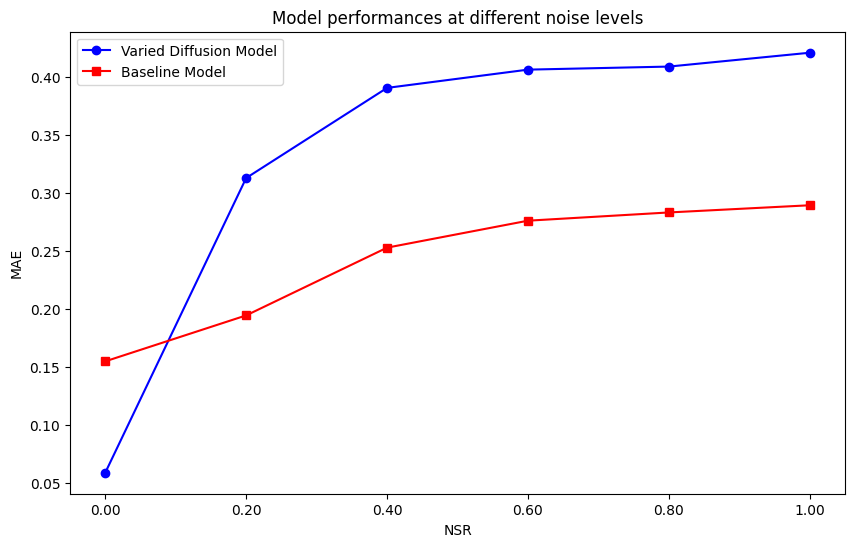

In [29]:
# NSR values
NSR = [0.00, 0.20, 0.40, 0.60, 0.80, 1.00]

# MAE values for the varied diffusion model
MAE_varied_diffusion = [MAE1, MAE5, MAE6, MAE7, MAE8, MAE9]

# MAE values for the original trajectory model
MAE_original_traj = [orig_MAE1, orig_MAE5, orig_MAE6, orig_MAE7, orig_MAE8, orig_MAE9]

# Plotting NSR vs MAE for varied diffusion model
plt.figure(figsize=(10, 6))
plt.plot(NSR, MAE_varied_diffusion, marker='o', linestyle='-', color='b', label='Varied Diffusion Model')

# Plotting NSR vs MAE for the original trajectory model
plt.plot(NSR, MAE_original_traj, marker='s', linestyle='-', color='r', label='Baseline Model')

# Adding labels and title
plt.xlabel('NSR')
plt.ylabel('MAE')
plt.title('Model performances at different noise levels')
plt.legend()
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Save plot as SVG
plt.savefig('NSR_vs_MAE_plot.svg', format='svg')

# Show plot
plt.show()

# Predictions

In [ ]:

# Preprocessing Experimental Data


# Differencing and Normalisation

differenced_data = data.groupby('pid').apply(differencing).reset_index(drop=True)

data_scaled = differenced_data.copy()

data_scaled['x'] = 2*(data_scaled['x'] - orig_xMin)/(orig_xMax- orig_xMin) - 1

data_scaled['y'] = 2*(data_scaled['y'] - orig_yMin)/(orig_yMax- orig_yMin) - 1


# Window Sequence Extraction

X_23_data = []  # Experimental Sequences

for id_value, group in data_scaled.groupby('pid'):
    for i in range(len(group) - 23):
        sequence = group.iloc[i:i + 23][['x', 'y']].values
        X_23_data.append(sequence)

X_23_data = np.array(X_23_data)

In [ ]:
# Experimental Data Prediction

experimental_hurst_predictions = baseline_model.predict(X_23_data)

125321/125321 ━━━━━━━━━━━━━━━━━━━━ 253s 2ms/step


In [ ]:
# Superdiffusion Count
Hurst_above_0_5 = np.sum(experimental_hurst_predictions > 0.5)

# Subdiffusion Count
Hurst_below_0_5 = np.sum(experimental_hurst_predictions < 0.5)

# Normal diffusion Count
H_0_5 = np.sum(experimental_hurst_predictions == 0.5)

print(f"H>0.5 Count: {Hurst_above_0_5}")
print(f"H<0.5 Count: {Hurst_below_0_5}")
print(f"H=0.5 Count: {H_0_5}")

H>0.5 Count: 3934424
H<0.5 Count: 75834
H=0.5 Count: 0


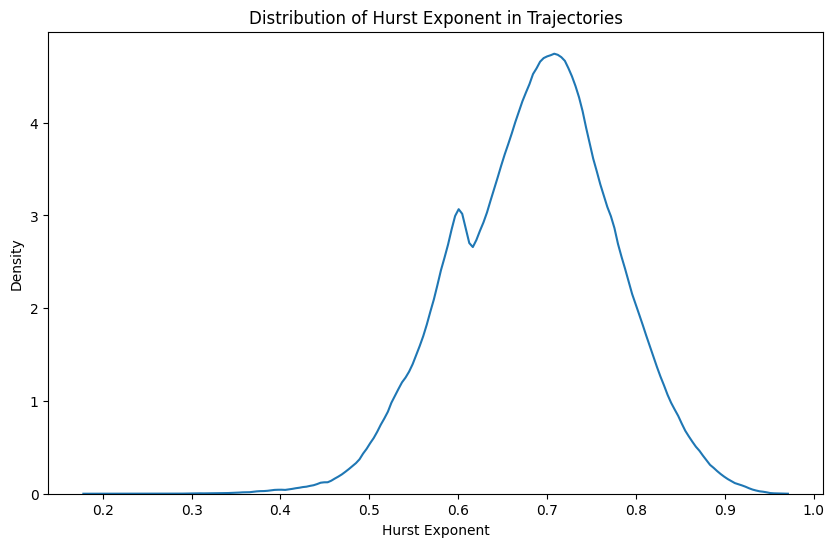

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(experimental_hurst_predictions, bw_adjust=0.5, legend= False, fill=False)

# Add labels and title
plt.xlabel('Hurst Exponent')
plt.ylabel('Density')
plt.title('Distribution of Hurst Exponent in Trajectories')

plt.savefig('hurst_distribution.svg', format='svg')

# Show plot
plt.show()

In [ ]:
print("Largest Hurst Prediction:", np.max(experimental_hurst_predictions))
print("Mean Hurst Prediction:", np.mean(experimental_hurst_predictions))
print("Smallest Hurst Prediction:", np.min(experimental_hurst_predictions))

Largest Hurst Prediction: 0.9647972
Mean Hurst Prediction: 0.68593764
Smallest Hurst Prediction: 0.1845252


In [ ]:
# Initialize variables
prediction_index = 0
pid_predictions = []

# Iterate through each pid and process sequences
for id_value, group in data_scaled.groupby('pid'):
    if len(group) > 23:
        num_sequences = len(group) - 23
        predictions = []
        for start_index in range(num_sequences):
            # Get the start index for this sequence
            sequence_start = group.index[start_index]

            # Get the prediction for this sequence
            prediction = experimental_hurst_predictions[prediction_index]
            predictions.append(prediction)
            prediction_index += 1

        # Append the (pid, predictions_list) tuple to the list
        pid_predictions.append((id_value, predictions))

# Find PIDs where all predictions are > 0.8
pids_all_above_0_8 = []

pids_all_below_0_4 =[]


pids_with_different_diffusions = []

for pid, values in pid_predictions:
    has_above_0_5 = any(value > 0.5 for value in values)
    has_below_0_5 = any(value < 0.5 for value in values)

    if has_above_0_5 and has_below_0_5:
        pids_with_different_diffusions.append(pid)

    if all(value > 0.8 for value in values):
        pids_all_above_0_8.append(pid)

    if all(value < 0.4 for value in values):
        pids_all_below_0_4.append(pid)

In [ ]:
print("PIDs with all predictions < 0.4:", pids_all_below_0_4)

PIDs with all predictions < 0.4: [4897, 5201, 5276, 6309, 18539, 18607, 18910, 19566, 19820, 20788, 21218, 21233, 21407, 21527, 26717, 27703, 28553, 28596, 28623, 28661, 29716, 29838, 30075, 30204, 31024, 31646, 32636, 33831, 34032, 35470, 35606, 35678, 36123, 36192, 36244, 36299, 36392, 36465, 36614, 36907, 37129, 37369, 37633, 38237, 38456, 39181, 39250, 39313, 39369, 39461, 39481, 39561, 40201, 40521, 41293, 45603, 45804, 52410, 61754, 65055, 65339, 67071, 85832, 88114, 88192, 88286, 101365]


In [ ]:
print("PIDs with all predictions > 0.8:", pids_all_above_0_8)

PIDs with all predictions > 0.8: [7249, 7254, 7259, 7285, 7306, 7374, 14094, 14138, 72040, 79677, 79693, 79707, 79750, 79767, 86080, 86117, 87008, 90833, 98750, 98807, 98809, 98813, 98816, 98855, 99300, 100192, 102377, 102794]


In [ ]:
print("PIDs with both >0.5 and <0.5 in the list:", pids_with_different_diffusions)

PIDs with both >0.5 and <0.5 in the list: [230, 419, 549, 651, 805, 953, 1009, 1126, 1202, 1351, 1446, 1658, 2022, 2361, 2584, 3265, 3272, 3611, 4479, 4866, 4867, 4871, 4877, 4892, 5515, 5604, 5617, 5688, 5807, 5992, 6015, 6043, 6062, 6179, 6402, 7251, 7539, 7568, 7577, 7722, 8222, 8263, 9446, 9618, 10087, 10218, 10289, 10290, 10344, 10351, 10359, 10366, 10370, 10436, 10575, 10583, 10851, 10945, 11183, 11259, 11493, 11555, 11674, 11679, 11691, 11791, 11801, 11852, 11933, 11993, 12077, 12095, 12945, 13037, 13078, 13442, 13477, 14110, 14141, 14596, 14649, 14881, 14972, 15145, 15147, 15151, 16815, 17087, 17125, 17223, 17228, 17273, 17308, 17333, 17403, 17497, 17645, 17673, 17797, 18119, 18131, 18283, 18347, 18350, 18351, 18353, 18355, 18356, 18360, 18361, 18362, 18365, 18366, 18372, 18376, 18378, 18384, 18385, 18386, 18388, 18392, 18393, 18395, 18397, 18398, 18400, 18416, 18437, 18459, 18460, 18462, 18477, 18479, 18480, 18486, 18491, 18496, 18510, 18545, 18558, 18561, 18588, 18590, 18602,

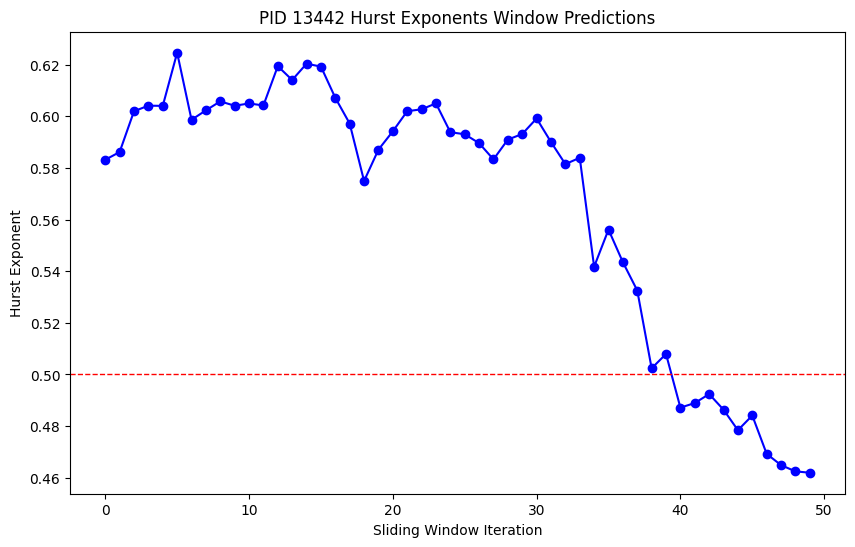

In [ ]:
# Prediction windows for pid 13442
hurst_pid13442 = [values for pid, values in pid_predictions if pid == 13442]


plt.figure(figsize=(10, 6))
plt.plot([i for i in range(len(hurst_pid13442[0]))], hurst_pid13442[0], marker='o', linestyle='-', color='b')
plt.xlabel('Sliding Window Iteration')
plt.ylabel('Hurst Exponent')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.title('PID 13442 Hurst Exponents Window Predictions')
plt.savefig('pid13442.svg', format='svg')
plt.show()

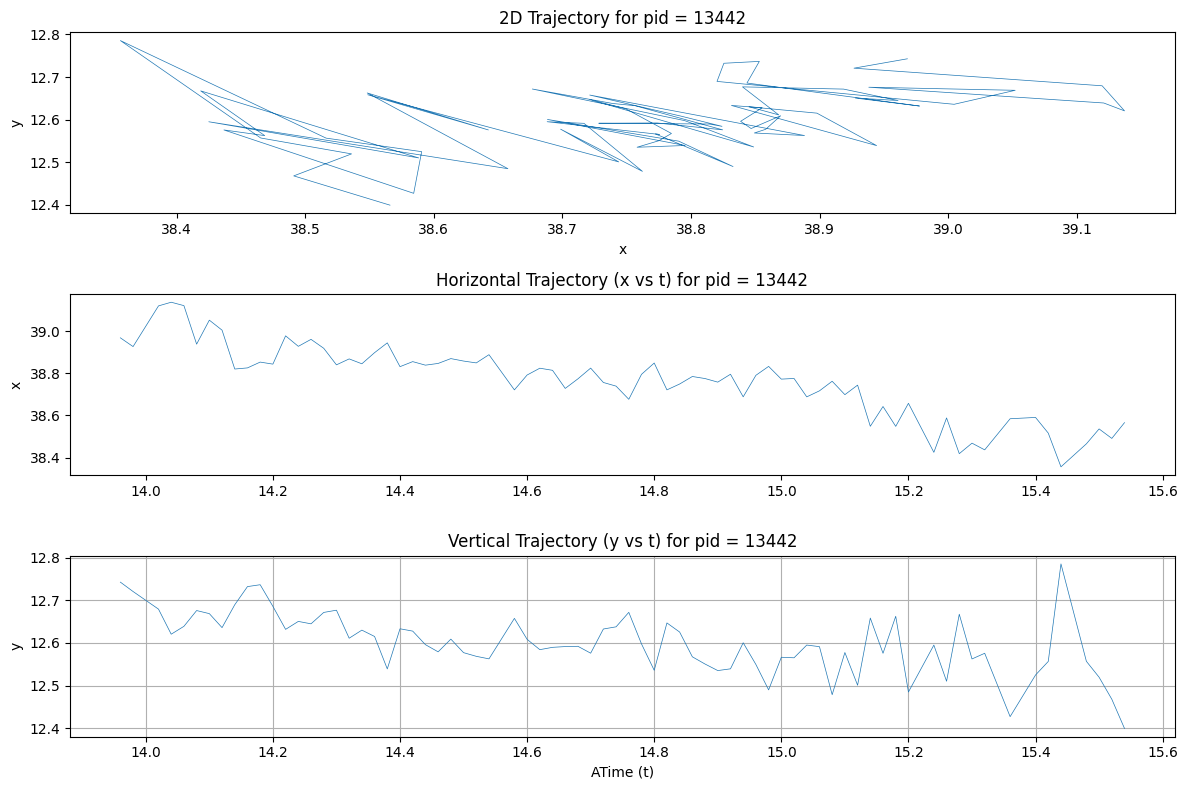

In [ ]:
# Filter data for pid = 13422
data_pid13442= data[data['pid'] == 13442]

# Plotting the 2D trajectory for pid = 13442
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(data_pid13442['x'], data_pid13442['y'], lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Trajectory for pid = 13442')


# Plotting the horizontal trajectory (x over time) for pid = 4995
plt.subplot(3, 1, 2)
plt.plot(data_pid13442['t'], data_pid13442['x'], lw=0.5)
plt.ylabel('x')
plt.title('Horizontal Trajectory (x vs t) for pid = 13442')


# Plotting the vertical trajectory (y over time) for pid = 13442
plt.subplot(3, 1, 3)
plt.plot(data_pid13442['t'], data_pid13442['y'], lw=0.5)
plt.xlabel('ATime (t)')
plt.ylabel('y')
plt.title('Vertical Trajectory (y vs t) for pid = 13442')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

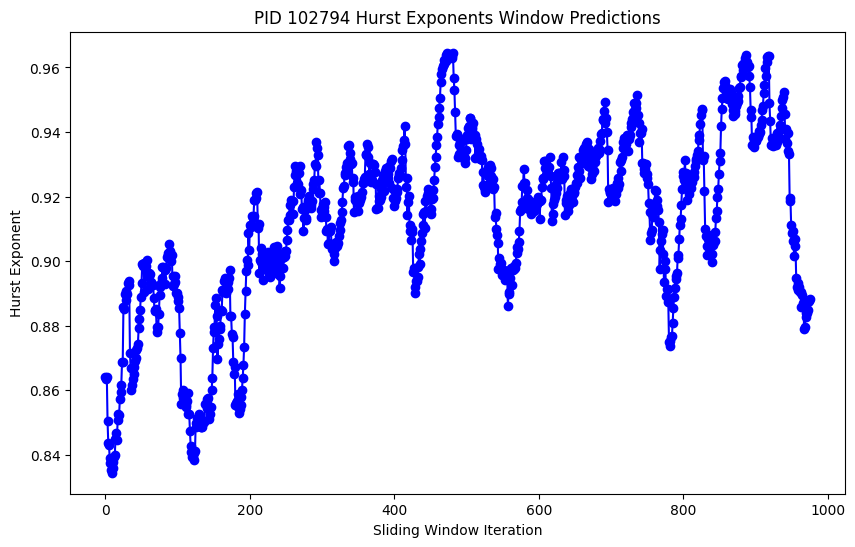

In [ ]:

# Prediction windows for pid 102794
hurst_pid102794 = [values for pid, values in pid_predictions if pid == 102794]

plt.figure(figsize=(10, 6))
plt.plot([i for i in range(len(hurst_pid102794[0]))], hurst_pid102794[0], marker='o', linestyle='-', color='b')
plt.xlabel('Sliding Window Iteration')
plt.ylabel('Hurst Exponent')
plt.title('PID 102794 Hurst Exponents Window Predictions')
plt.savefig('pid102794.svg', format='svg')
plt.show()

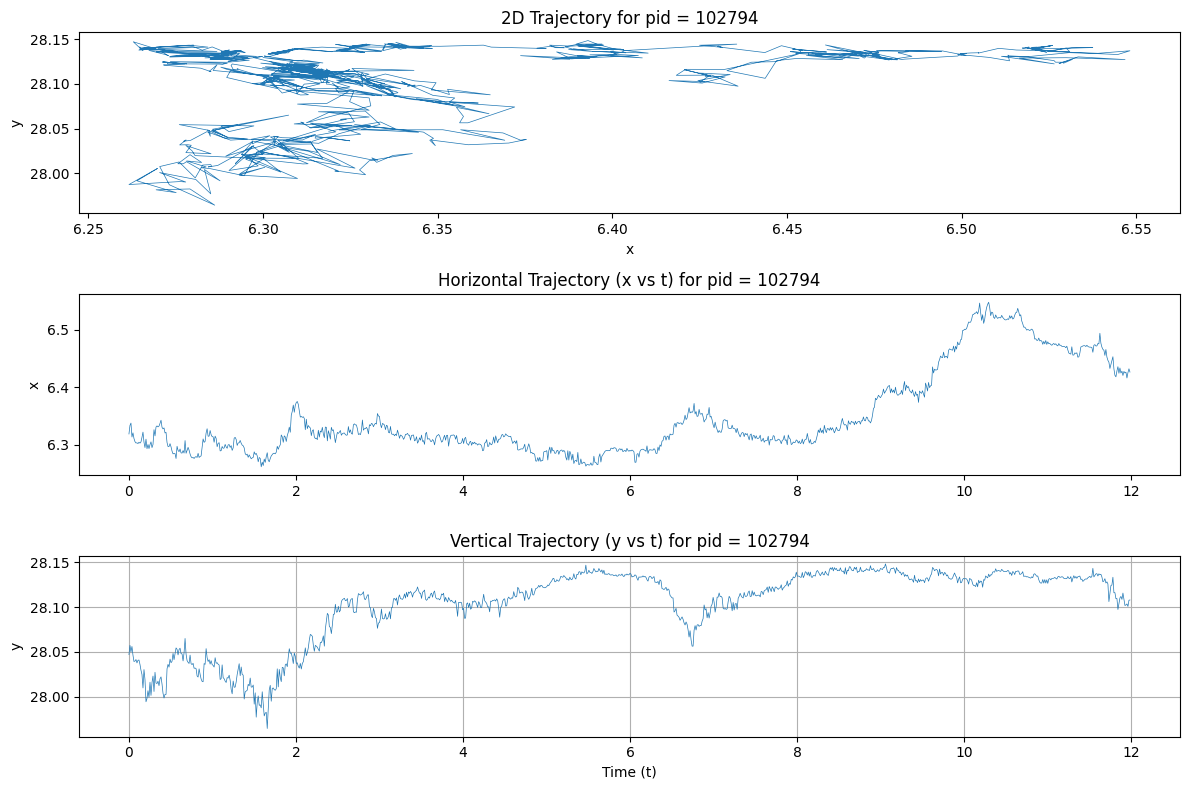

In [ ]:
# Filter data for pid = 102794
data_pid102794 = data[data['pid'] == 102794]

# Plotting the 2D trajectory for pid = 102794
plt.figure(figsize=(12, 8))

# 2D Trajectory
plt.subplot(3, 1, 1)
plt.plot(data_pid102794['x'], data_pid102794['y'], lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Trajectory for pid = 102794')

# Horizontal Trajectory (x over time)
plt.subplot(3, 1, 2)
plt.plot(data_pid102794['t'], data_pid102794['x'], lw=0.5)
plt.ylabel('x')
plt.title('Horizontal Trajectory (x vs t) for pid = 102794')

# Vertical Trajectory (y over time)
plt.subplot(3, 1, 3)
plt.plot(data_pid102794['t'], data_pid102794['y'], lw=0.5)
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Vertical Trajectory (y vs t) for pid = 102794')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

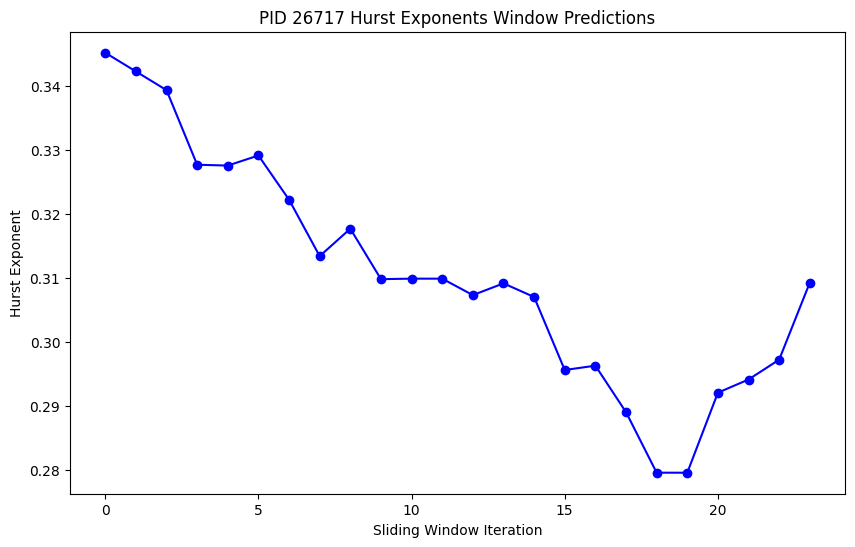

In [ ]:
# Prediction windows for pid 26717
hurst_pid26717 = [values for pid, values in pid_predictions if pid == 26717]

plt.figure(figsize=(10, 6))
plt.plot([i for i in range(len(hurst_pid26717[0]))], hurst_pid26717[0], marker='o', linestyle='-', color='b')
plt.xlabel('Sliding Window Iteration')
plt.ylabel('Hurst Exponent')
plt.title('PID 26717 Hurst Exponents Window Predictions')
plt.savefig('pid26717.svg', format='svg')
plt.show()